## Annotation enrichemts
enrichments for the lead variant for each phenotype, to rule out susie funny bussiness

TODO: redo this on a grouped dataset
run these vars though vep

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress
import upsetplot as up



from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *
from annotate_qtls import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [13]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

tissue_id = 'Adipose_Subcutaneous'
tissue_ids = tissue_ids[:11]

# load data

In [14]:
pcqtl_output_dir = config['pcqtl_output_dir']
pc_susie_df =  pd.read_csv(f'{prefix}/{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.susie.txt', sep='\t', index_col=0)
pc_susie_df['cluster_id'] = pc_susie_df['phenotype_id'].str.split('_pc').str[0]

eqtl_output_dir = config['eqtl_output_dir']
e_susie_df =  pd.read_csv(f'{prefix}/{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.susie.txt', sep='\t', index_col=0) 
e_susie_df['cluster_id'] = e_susie_df['phenotype_id'].str.split('_e').str[0]
combined_susie = pd.concat([e_susie_df, pc_susie_df], names=['type', 'idx'], keys=['pcqtl', 'eqtl']).reset_index(drop=0).drop(columns=['idx'])
# we will get af again from the nominals
combined_susie.drop(columns=['af'], inplace=True)

In [15]:
e_nominal_path_list = [f'{eqtl_output_dir}/{tissue_id}/{tissue_id}.v8.cluster_genes.cis_qtl_pairs.chr{CHROM}.parquet' for CHROM in range(1,23)]
pc_nominal_path_list = [f'{pcqtl_output_dir}/{tissue_id}/{tissue_id}.v8.pcs.cis_qtl_pairs.chr{CHROM}.parquet' for CHROM in range(1,23)]
e_nominal = pd.concat([pd.read_parquet(path) for path in e_nominal_path_list])
pc_nominal = pd.concat([pd.read_parquet(path) for path in pc_nominal_path_list])
qtls_nominal_merged = pd.merge(combined_susie, pd.concat([pc_nominal, e_nominal]), left_on=['phenotype_id', 'variant_id'],  right_on=['phenotype_id', 'variant_id'], how='left')
qtls_nominal_merged['qtl_variance'] = qtls_nominal_merged['slope'].apply(np.square) * 100
qtls_nominal_merged = qtls_nominal_merged.rename(columns={'slope':'qtl_slope', 'slope_se':'qtl_slope_se'})


KeyboardInterrupt: 

In [5]:
# add e nominal info
e_nominal_sub = e_nominal[e_nominal['variant_id'].isin(qtls_nominal_merged['variant_id'])]
e_nominal_sub['cluster_id'] = e_nominal_sub['phenotype_id'].str.split('_e').str[0]
e_nominal_sub['egene_id'] = e_nominal_sub['phenotype_id'].str.split('_e_').str[1]
e_nominal_sub['variance'] = e_nominal_sub['slope'].apply(np.square) * 100
egene_nominal = e_nominal_sub.groupby(['cluster_id', 'variant_id']).agg({'variance':list, 'egene_id':list, 'slope':list})
egene_nominal = egene_nominal.rename(columns={'variance':'eqtl_variance_list', 'egene_id':'egene_id_list', 'slope':'egene_qtl_slope'})
qtls_nominal_merged = pd.merge(qtls_nominal_merged, egene_nominal, left_on=['cluster_id', 'variant_id'], right_index=True, how='left')

/local/scratch/klawren/slrmtmp.46722292/ipykernel_5039/2248203524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_nominal_sub['cluster_id'] = e_nominal_sub['phenotype_id'].str.split('_e').str[0]
/local/scratch/klawren/slrmtmp.46722292/ipykernel_5039/2248203524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e_nominal_sub['egene_id'] = e_nominal_sub['phenotype_id'].str.split('_e_').str[1]
/local/scratch/klawren/slrmtmp.46722292/ipykernel_5039/2248203524.py:5: SettingWithCopyWarning: 
A value is try

In [6]:
qtl_annot_pc_merged = pd.merge(qtls_nominal_merged.explode(['egene_id_list', 'egene_qtl_slope', 'eqtl_variance_list']), 
                               annot_pc_rename[['pc_phenotype_id', 'egene_id', 'egene_pc_r2', 'egene_pc_slope']], 
                               right_on=['pc_phenotype_id', 'egene_id'], 
                               left_on=['phenotype_id', 'egene_id_list'], 
                               how='left')
qtl_annot_pc_merged = qtl_annot_pc_merged.drop(columns=['pc_phenotype_id', 'egene_id'])
qtl_annot_pc_merged['egene_qtl_slope_flipped'] = qtl_annot_pc_merged['egene_qtl_slope'] * qtl_annot_pc_merged['egene_pc_slope']


NameError: name 'annot_pc_rename' is not defined

In [84]:

qtls_nominal_merged = qtl_annot_pc_merged.groupby(['phenotype_id', 'variant_id','cs_id']).agg({'type':'first',
                                                                         'pip':'first', 
                                                                         'cluster_id':'first',
                                                                         'start_distance':'first',
                                                                         'end_distance':'first', 
                                                                         'af':'first',
                                                                         'ma_samples':'first',
                                                                         'ma_count':'first',
                                                                         'pval_nominal':'first',
                                                                         'qtl_slope':'first',
                                                                         'qtl_slope_se':'first',
                                                                         'qtl_variance':'first',
                                                                         'eqtl_variance_list':list,
                                                                         'egene_id_list':list,
                                                                         'egene_qtl_slope':list,
                                                                         'egene_pc_r2':list,
                                                                         'egene_pc_slope':list,
                                                                         'egene_qtl_slope_flipped':list}).reset_index()

In [86]:
sample_vep = pd.read_csv('{}/{}/{}.v8.leadvars.vep.vcf'.format(prefix, config['annotations_output_dir'], tissue_id), skiprows=4, sep='\t')

qtls = pd.merge(qtls_nominal_merged, sample_vep[['ID', 'INFO', 'POS', '#CHROM']], left_on='variant_id', right_on='ID', how='left').drop(columns=['ID'])
qtls.rename(columns={'INFO':'vep_info', 
                     'POS':'position', 
                     '#CHROM':'chr'}, inplace=True)
qtls['tissue_id'] = tissue_id

In [89]:
qtls.rename({'eqtl_variance_list':'egene_variance_list'}, inplace=True)

In [90]:
qtls['pip_weighted_af'] = qtls['af']*qtls['pip']

,phenotype_id,variant_id,cs_id,type,pip,cluster_id,start_distance,end_distance,af,ma_samples,...,eqtl_variance_list,egene_id_list,egene_qtl_slope,egene_pc_r2,egene_pc_slope,egene_qtl_slope_flipped,vep_info,position,chr,tissue_id
0,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,chr1_196382020_A_C_b38,1,pcqtl,0.022719,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,-227205,-437737,0.299484,294,...,"[0.0254044346511364, 0.040477149188518524, 0.0...","[ENSG00000162687.16, ENSG00000000971.15, ENSG0...","[0.015938768163323402, 0.02011893317103386, 0....","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
1,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,chr1_196388616_A_G_b38,1,pcqtl,0.022719,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,-220609,-431141,0.299484,294,...,"[0.0254044346511364, 0.040477149188518524, 0.0...","[ENSG00000162687.16, ENSG00000000971.15, ENSG0...","[0.015938768163323402, 0.02011893317103386, 0....","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
2,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,chr1_196390701_AT_A_b38,1,pcqtl,0.014714,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,-218524,-429056,0.298623,294,...,"[0.025557752698659897, 0.04008539766073227, 0....","[ENSG00000162687.16, ENSG00000000971.15, ENSG0...","[0.015986792743206024, 0.020021338015794754, 0...","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
3,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,chr1_196392367_G_T_b38,1,pcqtl,0.022719,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,-216858,-427390,0.299484,294,...,"[0.0254044346511364, 0.040477149188518524, 0.0...","[ENSG00000162687.16, ENSG00000000971.15, ENSG0...","[0.015938768163323402, 0.02011893317103386, 0....","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
4,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,chr1_196394414_G_A_b38,1,pcqtl,0.022719,ENSG00000000971.15_ENSG00000116785.13_ENSG0000...,-214811,-425343,0.299484,294,...,"[0.0254044346511364, 0.040477149188518524, 0.0...","[ENSG00000162687.16, ENSG00000000971.15, ENSG0...","[0.015938768163323402, 0.02011893317103386, 0....","[nan, nan, nan, nan]","[nan, nan, nan, nan]","[nan, nan, nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60507,ENSG00000278259.4_ENSG00000278311.4_e_ENSG0000...,chr17_36593168_T_C_b38,1,pcqtl,0.016641,ENSG00000278259.4_ENSG00000278311.4,49733,48280,0.422547,381,...,"[0.06092026084661484, 0.1022455021739006]","[ENSG00000278259.4, ENSG00000278311.4]","[-0.024682030081748962, 0.03197585046291351]","[nan, nan]","[nan, nan]","[nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
60508,ENSG00000278259.4_ENSG00000278311.4_e_ENSG0000...,chr17_36594407_T_C_b38,1,pcqtl,0.016641,ENSG00000278259.4_ENSG00000278311.4,50972,49519,0.422547,381,...,"[0.06092026084661484, 0.1022455021739006]","[ENSG00000278259.4, ENSG00000278311.4]","[-0.024682030081748962, 0.03197585046291351]","[nan, nan]","[nan, nan]","[nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
60509,ENSG00000278259.4_ENSG00000278311.4_e_ENSG0000...,chr17_36594661_C_T_b38,1,pcqtl,0.072772,ENSG00000278259.4_ENSG00000278311.4,51226,49773,0.423408,382,...,"[0.06137216091156006, 0.10404117405414581]","[ENSG00000278259.4, ENSG00000278311.4]","[-0.024773405864834785, 0.03225541487336159]","[nan, nan]","[nan, nan]","[nan, nan]",NaN,NaN,NaN,Adipose_Subcutaneous
60510,ENSG00000278259.4_ENSG00000278311.4_pc1,chr17_36485825_C_A_b38,1,eqtl,0.930050,ENSG00000278259.4_ENSG00000278311.4,-57610,-59063,0.404475,363,...,"[0.08745577931404114, 0.1001775935292244]","[ENSG00000278259.4, ENSG00000278311.4]","[-0.029572922736406326, 0.0316508449614048]","[0.6167639493331847, 0.6167638029442514]","[-0.7853431965565199, 0.7853430764334046]","[0.023224893673328327, 0.02485677195370637]",CSQ=A

In [93]:
qtls_cs_grouped = qtls.groupby(['phenotype_id', 'cs_id']).agg({'variant_id':list, 
                                             'pip':sum, 
                                             'type':'first',
                                             'cluster_id':'first',
                                             'af':'mean'})
qtls_cs_grouped

variant_id  \
phenotype_id                                       cs_id                                                      
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1      [chr1_196382020_A_C_b38, chr1_196388616_A_G_b3...   
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1                               [chr1_196740093_A_T_b38]   
                                                   2      [chr1_196690623_T_C_b38, chr1_196693329_T_C_b3...   
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1      [chr1_196379649_C_T_b38, chr1_196380022_C_T_b3...   
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1      [chr1_196853900_T_G_b38, chr1_196856834_A_G_b3...   
...                                                                                                     ...   
ENSG00000276293.4_ENSG00000277791.4_pc1            1       [chr17_38765943_A_G_b38, chr17_38769497_G_A_b38]   
                                                   2      [chr17_38764825_A_G_b38, chr17_38787934_C_T_b3...   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... 1                               [chr17_36485825_C_A_b38]   
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... 1      [chr17_36479673_A_T_b38, chr17_36517188_C_T_b3...   
ENSG00000278259.4_ENSG00000278311.4_pc1            1       [chr17_36485825_C_A_b38, chr17_36544998_A_C_b38]   

                                                               pip  
phenotype_id                                       cs_id            
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1      0.952197  
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1      0.993279  
                                                   2      0.959998  
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1      0.954390  
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1      0.965499  
...                                                            ...  
ENSG00000276293.4_ENSG00000277791.4_pc1            1      0.988358  
                                                   2      0.967988  
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... 1      0.960203  
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... 1      0.955699  
ENSG00000278259.4_ENSG00000278311.4_pc1            1      0.954433  

[3164 rows x 2 columns]

<AxesSubplot: xlabel='pip', ylabel='Count'>

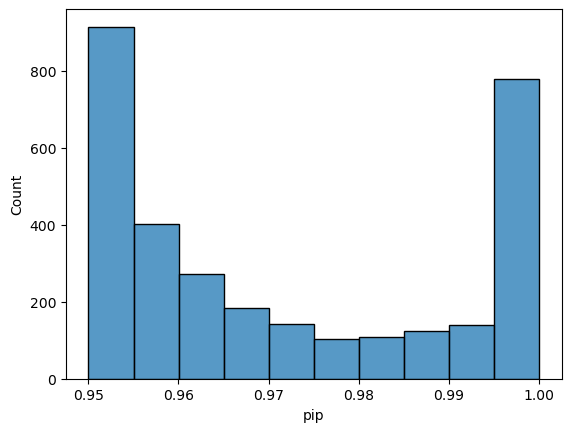

In [94]:
sns.histplot(qtls_cs_grouped, x='pip', bins=10)

In [ ]:
# moving into credible set stuff, for each pc phenotype have the pip weighted qtl_varaince for each egene in the cluster

In [118]:
# get the max pip weighted egene var for each credible set
qtls_nominal_merged_e  = pd.merge(qtls_nominal_merged, max_egene_var.rename(columns={'variance':'e_variance_list', 'egene_id':'egene_id_list'}), left_on=['cluster_id', 'variant_id'], right_index=True, how='left')
qtls_nominal_merged_explode = qtls_nominal_merged_e.explode(['e_variance_list', 'egene_id_list'])
qtls_nominal_merged_explode['pip_weighted_egene_var'] = qtls_nominal_merged_explode['pip'] * qtls_nominal_merged_explode['e_variance_list']
grouped_egene_vars = qtls_nominal_merged_explode.groupby(['phenotype_id', 'cs_id', 'egene_id_list']).agg({'pip_weighted_egene_var':sum})
grouped_egene_vars['pip_weighted_egene_var'] = grouped_egene_vars['pip_weighted_egene_var'].astype(float)
max_egene_vars = grouped_egene_vars.loc[grouped_egene_vars.groupby(['phenotype_id', 'cs_id'])['pip_weighted_egene_var'].idxmax()]

# add that info back to the df

max_egene_vars

pip_weighted_egene_var
phenotype_id                                       cs_id egene_id_list                             
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1     ENSG00000000971.15                0.026881
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1     ENSG00000116785.13                0.105659
                                                   2     ENSG00000116785.13                0.013414
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1     ENSG00000000971.15                0.004882
ENSG00000000971.15_ENSG00000116785.13_ENSG00000... 1     ENSG00000116785.13                0.056393
...                                                                                             ...
ENSG00000276293.4_ENSG00000277791.4_pc1            1     ENSG00000276293.4                 0.058932
                                                   2     ENSG00000276293.4                 0.255506
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... 1     ENSG00000278311.4                 0.096191
ENSG00000278259.4_ENSG00000278311.4_e_ENSG00000... 1     ENSG00000278311.4                 0.065419
ENSG00000278259.4_ENSG00000278311.4_pc1            1     ENSG00000278311.4                 0.093170

[3163 rows x 1 columns]

## old cocde

In [16]:
# load in the gene information 
gid_gencode, full_gencode = load_gencode()

In [17]:
pcqtls = load_across_tissues(config, load_pc_cis)
pcqtls['type'] = 'pcqtl'
eqtls = load_across_tissues(config, load_e_cis)
eqtls['pc_num'] = 0
eqtls['cluster_size'] = eqtls['cluster_id'].str.split('_').apply(len)
eqtls['type'] = 'eqtl'
eqtls['pc_order'] = 'eqtl'

qtls = pd.concat([pcqtls, eqtls]).reset_index()
qtls = qtls[qtls['qval'] < .05]

In [28]:
# add effect size to qtls in egene space
# effect size is in pc units, needs to be converted into e gene units
# take the larget effect size for any egene


def add_variance(nominal_df):
    nominal_df['variance'] = nominal_df['slope'].apply(np.square) * 100

var_annot_qtls = []
for my_tissue_id in tqdm(qtls['tissue_id'].unique()):

    sub_qtls = qtls[qtls['tissue_id'] == my_tissue_id]
    e_nominal = load_e_nominal_all_chr(config, my_tissue_id)
    pc_nominal = load_pc_nominal_all_chr(config, my_tissue_id)

    vid_pc_nominal = pc_nominal.set_index('variant_id')
    vid_pc_nominal = vid_pc_nominal.loc[sub_qtls['variant_id']]

    vid_e_nominal = e_nominal.set_index('variant_id')
    vid_e_nominal = vid_e_nominal.loc[sub_qtls['variant_id']]
    add_variance(vid_e_nominal)

    vid_e_nominal_grouped = vid_e_nominal.groupby('variant_id').agg({'variance':max}).reset_index()

    vid_pc_nominal_mereged = pd.merge(vid_pc_nominal.reset_index(), vid_e_nominal_grouped, 
            suffixes=['_pc', '_e'], how='left', left_on='variant_id', right_on='variant_id')

    sub_qtls_pc = pd.merge(sub_qtls, vid_pc_nominal_mereged[['variant_id', 'phenotype_id', 'variance']], 
            left_on=['variant_id', 'phenotype_id'], right_on=['variant_id', 'phenotype_id'], how='left')

    sub_qtls_pc = pd.merge(sub_qtls_pc, vid_e_nominal.reset_index()[['variant_id', 'phenotype_id', 'variance']], 
            left_on=['variant_id', 'phenotype_id'], right_on=['variant_id', 'phenotype_id'], how='left')
    sub_qtls_pc['variance'] = np.where(sub_qtls_pc['variance_x'].isna(), sub_qtls_pc['variance_y'], sub_qtls_pc['variance_x'])
    sub_qtls_pc['tissue_id'] = my_tissue_id
    var_annot_qtls.append(sub_qtls_pc)

var_annot_qtls = pd.concat(var_annot_qtls).drop_duplicates()   
var_annot_qtls[['phenotype_id', 'tissue_id', 'variant_id', 'variance']].to_csv('{}/{}/var_annotated_qtls.csv'.format(prefix, config['annotations_output_dir'])) 

100%|███████████████████████████████████████████████████████████████████████████████████████| 13/13 [37:47<00:00, 174.46s/it]


In [19]:
var_annot_qtls = pd.read_csv('{}/{}/var_annotated_qtls.csv'.format(prefix, config['annotations_output_dir']), index_col=0)
qtls = pd.merge(var_annot_qtls, qtls, left_on=['phenotype_id', 'tissue_id', 'variant_id'], right_on = ['phenotype_id', 'tissue_id', 'variant_id'])

FileNotFoundError: [Errno 2] No such file or directory: '/home/klawren/oak/pcqtls/output/proteincoding_main/annotations//var_annotated_qtls.csv'

<AxesSubplot: xlabel='variance', ylabel='Count'>

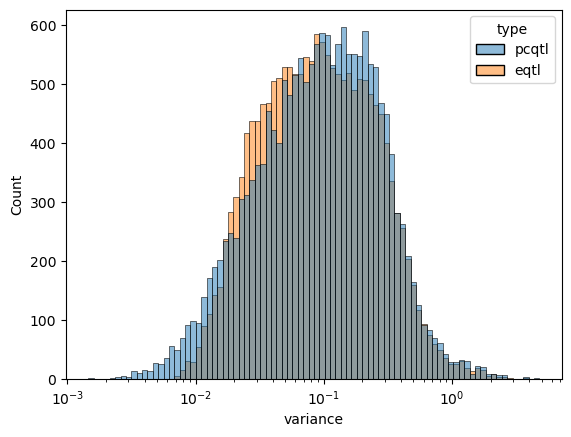

In [16]:
sns.histplot(qtls, x='variance', hue='type', log_scale=True)

In [26]:
# group by lead variant to prevent varaints from being double counted
qtls_grouped = qtls.groupby(['variant_id', 'tissue_id', 'cluster_id']).agg({'phenotype_id':list, 
                                                                                'af':'first', 
                                                                                'qval':list, 
                                                                                'pval_perm':list, 
                                                                                'type':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'variance':max}).reset_index() # you could also do a list of varainces
qtls_grouped['num_e_samelead'] = qtls_grouped['phenotype_id'].astype(str).str.count('_e')
qtls_grouped['num_pc_samelead'] = qtls_grouped['phenotype_id'].astype(str).str.count('_pc')
qtls_grouped['exclusive_label'] = np.where((qtls_grouped['num_e_samelead'] > 0), np.where((qtls_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

In [25]:
print('pcqtls {}'.format((qtls_grouped['num_pc_samelead'] > 0).sum()))
print('eqtls {}'.format((qtls_grouped['num_e_samelead'] > 0).sum()))

NameError: name 'qtls_grouped' is not defined

In [20]:
sns.histplot(qtls_grouped.explode('pc_order'), hue='exclusive_label', x='pc_order', common_norm=False, multiple='dodge', stat='percent')

NameError: name 'qtls_grouped' is not defined

In [21]:
sns.histplot(qtls_grouped, hue='exclusive_label', x='cluster_size', common_norm=False, multiple='dodge', stat='percent', bins=range(2, 10))

NameError: name 'qtls_grouped' is not defined

In [22]:
qtls_grouped['eQTL'] = qtls_grouped['num_e_samelead'] > 0
qtls_grouped['pcQTL'] = qtls_grouped['num_pc_samelead'] > 0
qtls_grouped['multiple_e_shared_label'] = np.where((qtls_grouped['num_e_samelead'] > 1), 'multiple eQTL', 'single eQTL')
qtls_grouped['multiple_e_shared_label'] = np.where(qtls_grouped['num_e_samelead'] > 0, qtls_grouped['multiple_e_shared_label'], 'exclusive pcQTL')

upset = qtls_grouped.set_index('eQTL').set_index('pcQTL', append=True)


fig = plt.figure(figsize=(10, 10))
upset = up.UpSet(upset, intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

upset.plot(fig=fig)

plt.grid(False)
plt.legend(loc='upper right')
plt.gca().get_legend().set_frame_on(False)



plt.suptitle('Single lead var sharing')
plt.show()

NameError: name 'qtls_grouped' is not defined

In [23]:
pc_order_upset = pd.DataFrame(up.from_memberships(qtls_grouped['pc_order']))
pc_order_upset['multiple_e_shared_label'] = qtls_grouped['multiple_e_shared_label'].values

fig = plt.figure(figsize=(8, 6))
upset = up.UpSet(pc_order_upset, subset_size="count", intersection_plot_elements=0,show_counts=False, element_size=None)  # disable the default bar chart
upset.add_stacked_bars(by="multiple_e_shared_label", title="Count", elements=8, colors=('#B83A4B', '#016895', '#67AFD2'))

params = {"legend.fontsize": 10}
with plt.rc_context(params):
    upset.plot(fig=fig)

plt.grid(False)


plt.suptitle('Single lead var sharing')
plt.show()

NameError: name 'qtls_grouped' is not defined

#### average expression
no real difference here

In [23]:
def load_avg_exression(avg_expression_path = f'{prefix}/data/processed/GTEx_Analysis_RSEMv1.gene_tpm.tissue_avg.csv'):
    tissue_avg_expression = pd.read_csv(avg_expression_path, sep='\t', index_col=0)
    return tissue_avg_expression

def annotate_avg_expression(qtls, tissue_avg_expression):
    for idx, row in tqdm(qtls.iterrows(), total=len(qtls)):
        transcript_list = row['cluster_id'].split('_')
        cluster_avg_expression = tissue_avg_expression.loc[row['tissue_id'],transcript_list]
        qtls.loc[idx, 'avg_expression'] = np.mean(cluster_avg_expression)
        qtls.loc[idx, 'avg_log_expression'] = np.mean(np.log10(cluster_avg_expression))
        qtls.loc[idx, 'median_expression'] = np.median(cluster_avg_expression)
        qtls.loc[idx, 'min_expression'] = np.min(cluster_avg_expression)



annotate_avg_expression(qtls_grouped, load_avg_exression())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27877/27877 [00:46<00:00, 603.86it/s]


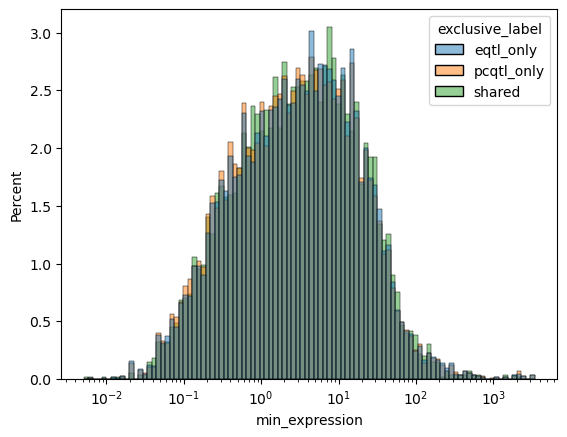

In [24]:
ax=sns.histplot(data=qtls_grouped, hue='exclusive_label', x='min_expression', stat='percent', common_norm=False, bins=100, log_scale=True)


pc eigenvalue

In [25]:
# pc_dfs = []
# for tissue_id in load_tissue_ids(config):    
#     pc_df = load_pc(config, tissue_id)
#     expression_df = load_cluster_expression(config, tissue_id)  
#     sample_ids = pc_df.columns[pc_df.columns.str.contains('GTEX')]
#     for idx, row in tqdm(pc_df.iterrows(), total=pc_df.shape[0]):
#         expression_cluster = expression_df[expression_df['cluster_id'] == row['cluster_id']].reset_index()
#         gene_variances = []
#         for i in range(len(expression_cluster)):
#             # pull the right data
#             pc_values = row[sample_ids].astype('float')
#             expression_values = expression_cluster.loc[i, sample_ids].astype('float')
#             # get the r squared value
#             slope, intercept, r_value, p_value, std_err = linregress(pc_values, expression_values)
#             gene_variances.append((r_value**2)*100)
#         gene_variances.sort()
#         pc_df.loc[idx, 'largest_variance'] = gene_variances[-1]
#         pc_df.loc[idx, 'second_largest_variance'] = gene_variances[-2]
#         pc_df.loc[idx, 'total_variance'] = sum(gene_variances)
#         pc_df.loc[idx, 'variance_list'] = str(gene_variances)
#     pc_df['tissue_id'] = tissue_id
#     pc_dfs.append(pc_df)

# #write out
# pc_df = pd.concat(pc_dfs)
# pc_df = pc_df.copy()
# pc_df['chr'] = pc_df['#chr']
# pc_df = pc_df[['chr', 'start', 'end', 'gene_id', 'tissue_id', 'largest_variance', 'second_largest_variance', 'total_variance', 'variance_list']]
# pc_df.to_csv('{}/{}/pc_annotated.csv'.format(prefix, config['pc_output_dir']), index=None)

In [26]:
#load in 
pc_df = pd.read_csv('{}/{}/pc_annotated.csv'.format(prefix, config['pc_output_dir']))
pc_df['pc_num'] = pc_df['gene_id'].str.split('_pc').str[-1].astype(int)
pc_df['cluster_size'] = pc_df['gene_id'].str.split('_').apply(len) - 1
pc_df['pc_order'] = 'middle'
pc_df.loc[pc_df['pc_num'] == pc_df['cluster_size'],'pc_order'] = 'last'
pc_df.loc[pc_df['pc_num'] == 1,'pc_order'] = 'first'

In [27]:
pcqtls_var_annot = pd.merge(qtls_grouped.explode('phenotype_id'), pc_df, left_on=['tissue_id', 'phenotype_id'], right_on=['tissue_id', 'gene_id'], how='right')
pcqtls_var_annot['exclusive_label'] = pcqtls_var_annot['exclusive_label'].fillna('neither')

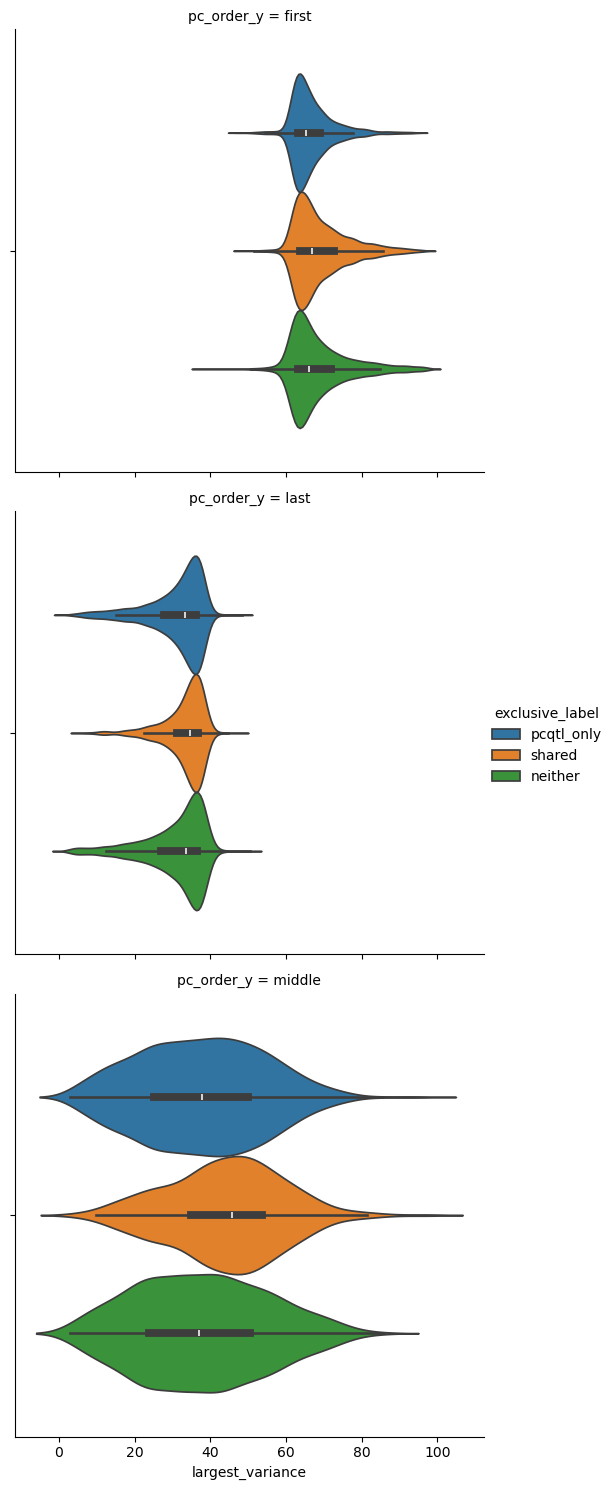

In [28]:
sns.catplot(pcqtls_var_annot, kind='violin', x='largest_variance', row='pc_order_y', hue='exclusive_label')

<AxesSubplot: xlabel='frac_var', ylabel='Percent'>

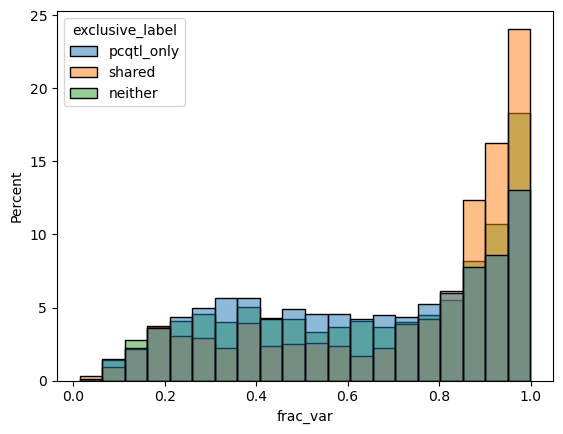

In [29]:
pcqtls_var_annot['frac_var'] = pcqtls_var_annot['second_largest_variance']/pcqtls_var_annot['largest_variance']
sns.histplot(data=pcqtls_var_annot[(pcqtls_var_annot['cluster_size_y']>2)], hue='exclusive_label', 
                      x='frac_var', common_norm=False, stat='percent', 
                      hue_order=['pcqtl_only', 'shared', 'neither'], bins=20)

effect size

Text(0.5, 0, 'maximum egene % variance explained')

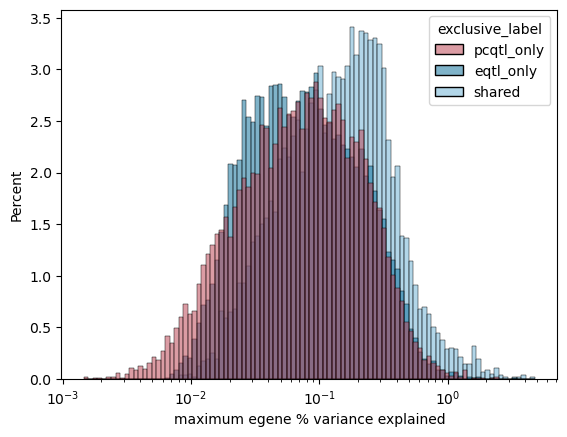

In [43]:
# pcqtls have smaller effect sizes
ax = sns.histplot(qtls_grouped, x='variance', hue='exclusive_label', log_scale=True, common_norm=False, bins=100, stat='percent',
                               palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#016895', 'shared':'#67AFD2'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])

ax.set_xlabel('maximum egene % variance explained')

In [56]:
qtls_grouped.explode('pc_order')['variance']


0        0.770594
1        0.258290
2        0.218500
3        0.694224
4        0.029469
           ...   
27872    0.116437
27873    0.277315
27874    0.211239
27875    0.017076
27876    0.018830
Name: variance, Length: 34901, dtype: float64

Text(0.5, 0, 'maximum egene % variance explained')

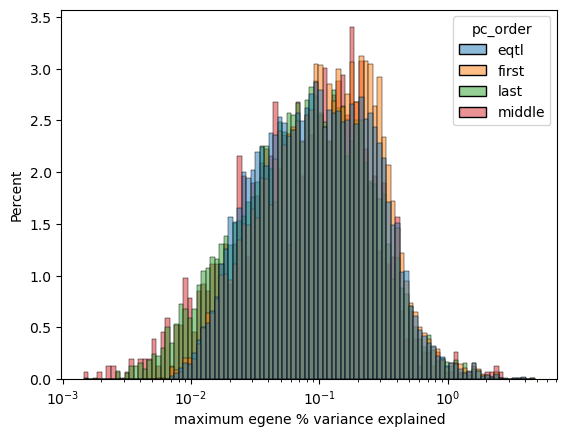

In [60]:
qtls_grouped_exploded = qtls_grouped.explode('pc_order')
ax = sns.histplot(qtls_grouped_exploded, x='variance', hue='pc_order', log_scale=True, common_norm=False, bins=100, stat='percent')
ax.set_xlabel('maximum egene % variance explained')

NameError: name 'qtls_grouped' is not defined

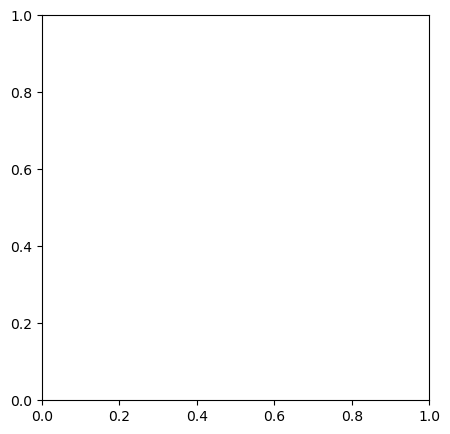

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
sns.kdeplot(qtls_grouped, x='variance', hue='exclusive_label', common_norm=False, log_scale=True, ax=ax,
                                           palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#67AFD2', 'shared':'#734675'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])
ax.set_xlabel('Maximum egene % expression variance explained')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('QTL Type')

# Change legend labels
leg_texts = ['pcQTL only', 'eQTL only', 'Both']
for text, new_label in zip(leg.texts, leg_texts):
    text.set_text(new_label)

In [ ]:
# pcqtls have smaller effect sizes
ax = sns.histplot(qtls_grouped, x='variance', hue='exclusive_label', log_scale=True, common_norm=False, bins=100, stat='percent',
                               palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#016895', 'shared':'#67AFD2'}, hue_order=['pcqtl_only', 'eqtl_only', 'shared'])

ax.set_xlabel('maximum egene % variance explained')

Text(0.5, 0, 'maximum egene % variance explained')

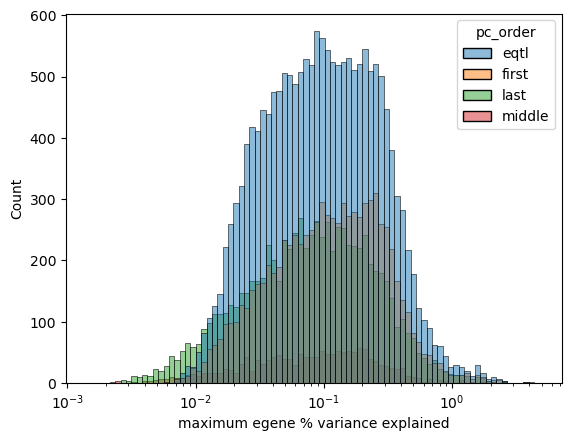

In [31]:
# mostly last pcs
ax = sns.histplot(qtls_grouped.explode(['pc_order']), x='variance', hue='pc_order', log_scale=True)
ax.set_xlabel('maximum egene % variance explained')

abc

In [32]:
full_abc_path= '/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/AllPredictions.AvgHiC.ABC0.015.minus150.ForABCPaperV3.txt.gz'
abc_match_path='/home/klawren/oak/pcqtls/data/references/functional_annotations/ABC_predictions/ABC_matched_gtex.csv'   
full_abc_pred_df = pd.read_csv(full_abc_path, sep='\t')
abc_gtex_match = pd.read_csv(abc_match_path)

full_abc_pred_df = full_abc_pred_df[full_abc_pred_df['CellType'].isin(abc_gtex_match['ABC_biosample_id'])]
gene_enhancer_df = pd.merge(full_gencode[['transcript_id', 'gene_name']], full_abc_pred_df[['chr', 'start', 'end', 'TargetGene','name','class', 'ABC.Score', 'CellType']], left_on='gene_name', right_on='TargetGene', how='left')
gene_enhancer_df.rename(columns={'name':'enhancer'}, inplace=True)
gene_enhancer_df.set_index('transcript_id', inplace=True)
gene_enhancer_df.dropna(inplace=True)

gene_enhancer_df['chr'] = gene_enhancer_df['chr'].str.split('chr').str[1]
gene_enhancer_df = gene_enhancer_df[gene_enhancer_df['chr'].isin(f'{i+1}' for i in range(22))]
gene_enhancer_df['chr'] = gene_enhancer_df['chr'].astype(int)
gene_enhancer_df['enhancer_start'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[0].astype(int)
gene_enhancer_df['enhancer_end'] = gene_enhancer_df['enhancer'].str.split(':').str[1].str.split('-').str[1].astype(int)

<AxesSubplot: xlabel='enhancer_size', ylabel='Count'>

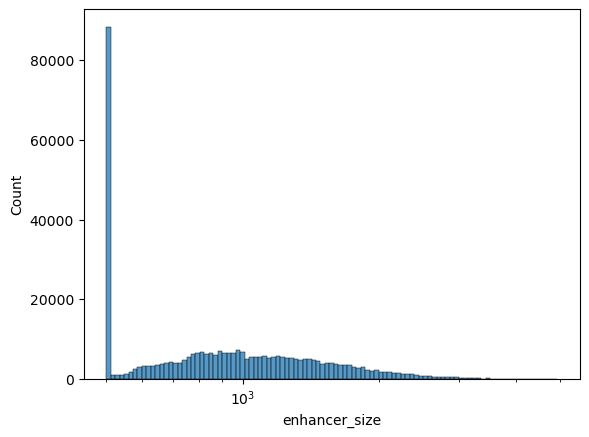

In [33]:
gene_enhancer_df['enhancer_size'] = gene_enhancer_df['enhancer_end'] - gene_enhancer_df['enhancer_start']
sns.histplot(gene_enhancer_df['enhancer_size'], log_scale=True)

In [34]:
gene_enhancer_df['size_bool'] = gene_enhancer_df['enhancer_size'] == 500

<AxesSubplot: xlabel='ABC.Score', ylabel='Count'>

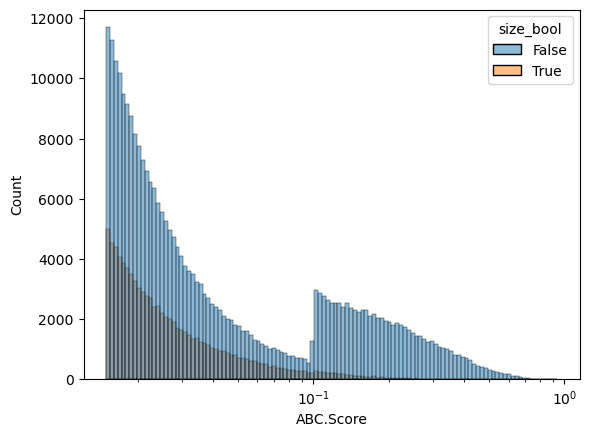

In [35]:
sns.histplot(gene_enhancer_df, x='ABC.Score', hue='size_bool', log_scale=True)

In [36]:
qtls_grouped['chr'] = qtls_grouped['variant_id'].str.split('_').str[0].str.strip('chr').astype(int)
qtls_grouped['position'] = qtls_grouped['variant_id'].str.split('_').str[1].astype(int)

In [37]:
for tissue_id, sub_qtl in qtls_grouped.groupby('tissue_id'):
    tissue_enhancers = gene_enhancer_df[gene_enhancer_df['CellType'] == abc_gtex_match[abc_gtex_match['GTEX_tissue'] == tissue_id]['ABC_biosample_id'].iloc[0]]
    print(tissue_id)
    print(len(tissue_enhancers))
    for idx, qtl_row in tqdm(sub_qtl.iterrows(), total=len(sub_qtl)):
        matched_enhancers = tissue_enhancers[(tissue_enhancers['chr'] == qtl_row['chr'])&(tissue_enhancers['enhancer_start'] <= qtl_row['position'])&(tissue_enhancers['enhancer_end'] >= qtl_row['position'])]
        all_enhancers = gene_enhancer_df[(gene_enhancer_df['chr'] == qtl_row['chr'])&(gene_enhancer_df['enhancer_start'] <= qtl_row['position'])&(gene_enhancer_df['enhancer_end'] >= qtl_row['position'])]

        # is qtl in any abc enhancer?
        qtls_grouped.loc[idx, 'qtl_num_abc_enhancers'] = matched_enhancers['enhancer'].nunique()
        qtls_grouped.loc[idx, 'qtl_num_abc_all_enhancers'] = all_enhancers['enhancer'].nunique()
        # how many genes does the enhancer contact?
        qtls_grouped.loc[idx, 'qtl_num_abc_genes'] = matched_enhancers['TargetGene'].nunique()
        qtls_grouped.loc[idx, 'qtl_num_abc_all_genes'] = all_enhancers['TargetGene'].nunique()
        # how many cluster genes?
        qtls_grouped.loc[idx, 'qtl_matched_abc_genes'] = pd.Series(matched_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()
        qtls_grouped.loc[idx, 'qtl_matched_abc_all_genes'] = pd.Series(all_enhancers.reset_index()['transcript_id'].unique()).isin(qtl_row['cluster_id'].split('_')).sum()


Adipose_Subcutaneous
47836


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2645/2645 [00:19<00:00, 135.62it/s]


Adipose_Visceral_Omentum
0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1927/1927 [00:14<00:00, 128.71it/s]


Artery_Tibial
46844


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2674/2674 [00:18<00:00, 143.02it/s]


Cells_Cultured_fibroblasts
47242


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2773/2773 [00:19<00:00, 138.86it/s]


Esophagus_Mucosa
0


 30%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 745/2523 [00:04<00:11, 153.04it/s]


KeyboardInterrupt: 

In [ ]:
print('total qtls: {}'.format(len(qtls_grouped)))
print('qtls in enhancers in matched tissue: {}'.format((qtls_grouped['qtl_num_abc_enhancers'] > 0).sum()))
print('qtls in enhancers in any tissue: {}'.format((qtls_grouped['qtl_num_abc_all_enhancers'] > 0).sum()))

print('qtls in enhancer regulating at least one cluster genes in matched tissue: {}'.format((qtls_grouped['qtl_matched_abc_genes'] > 0).sum()))
print('qtls in enhancer regulating at least one cluster genes in any tissue: {}'.format((qtls_grouped['qtl_matched_abc_all_genes'] > 0).sum()))


print('qtls in enhancer regulating multiple cluster genes in matched tissue: {}'.format((qtls_grouped['qtl_matched_abc_genes'] > 1).sum()))
print('qtls in enhancer regulating multiple cluster genes in any tissue: {}'.format((qtls_grouped['qtl_matched_abc_all_genes'] > 1).sum()))


total qtls: 27877
qtls in enhancers in matched tissue: 322
qtls in enhancers in any tissue: 1335
qtls in enhancer regulating at least one cluster genes in matched tissue: 116
qtls in enhancer regulating at least one cluster genes in any tissue: 488
qtls in enhancer regulating multiple cluster genes in matched tissue: 41
qtls in enhancer regulating multiple cluster genes in any tissue: 218


In [ ]:
qtls_grouped['qlt_in_enhancer'] = qtls_grouped['qtl_num_abc_enhancers'] > 0
qtls_grouped['qlt_in_multitissue_enhancer'] = qtls_grouped['qtl_num_abc_all_enhancers'] > 1
qtls_grouped['qlt_in_cluster_enhancer'] = qtls_grouped['qtl_matched_abc_genes'] > 0
qtls_grouped['qlt_in_multiple_gene_cluster_enhancer'] = qtls_grouped['qtl_matched_abc_genes'] > 1


Text(0.5, 1.0, 'QTL in enhancer in Matched tissue regulating multiple cluster genes')

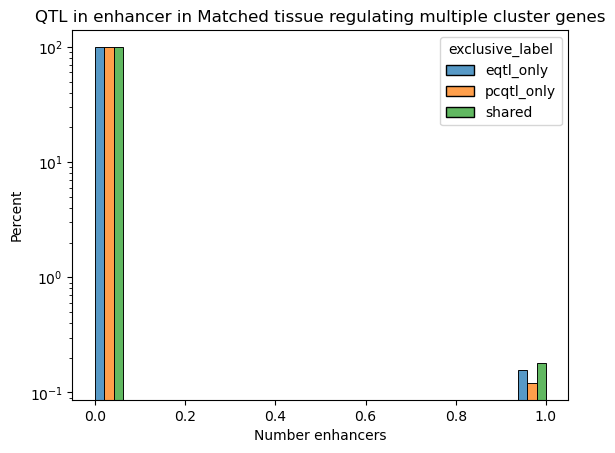

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qlt_in_multiple_gene_cluster_enhancer', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')
plt.xlabel('Number enhancers')
plt.title('QTL in enhancer in Matched tissue regulating multiple cluster genes')

Text(0.5, 1.0, 'QTL in enhancer in Matched tissue regulating cluster gene')

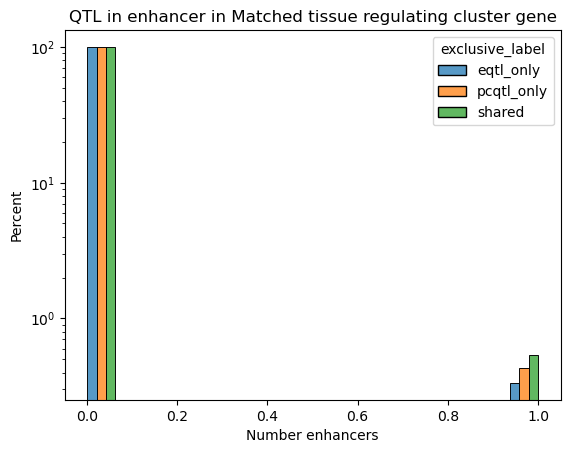

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qlt_in_cluster_enhancer', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')
plt.xlabel('Number enhancers')
plt.title('QTL in enhancer in Matched tissue regulating cluster gene')

Text(0.5, 1.0, 'QTL in enhancer in Matched tissue')

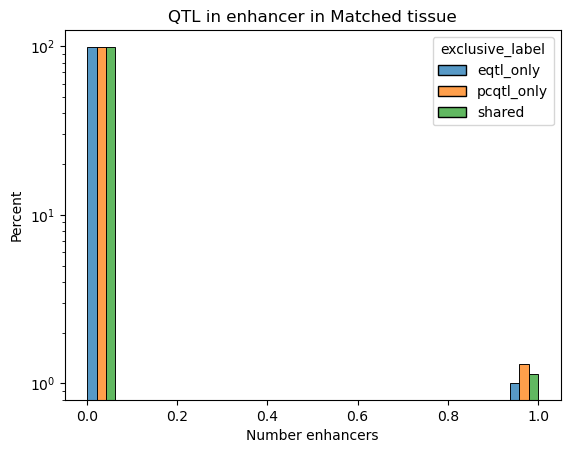

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qlt_in_enhancer', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')
plt.xlabel('Number enhancers')
plt.title('QTL in enhancer in Matched tissue')

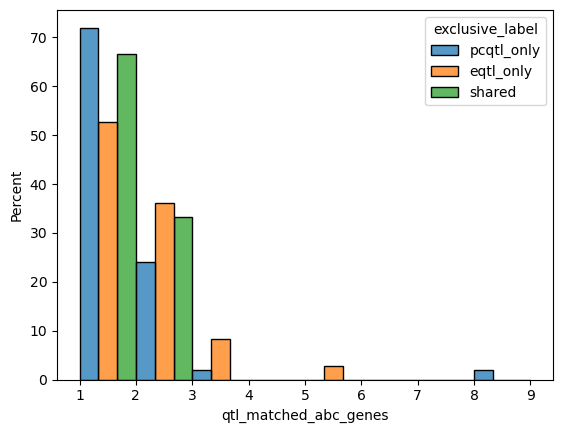

In [ ]:
ax = sns.histplot(data=qtls_grouped[qtls_grouped['qlt_in_enhancer']], hue='exclusive_label', x='qtl_matched_abc_genes', common_norm=False, stat='percent', multiple='dodge', bins=range(1, 10))


tad

In [ ]:
tad_df = load_tad()
qtls_grouped['qtl_inter'] = pd.arrays.IntervalArray.from_arrays(qtls_grouped['position'], qtls_grouped['position']+5000) # 10kb tad resolution
qtls_grouped['num_tads_qtl'] = qtls_grouped.progress_apply(count_tad_overlap, axis=1, args=(tad_df, 'qtl_inter'))
qtls_grouped['qtl_in_tad'] = qtls_grouped['num_tads_qtl'] > 1

 ... (more hidden) ...


(0.0, 10.0)

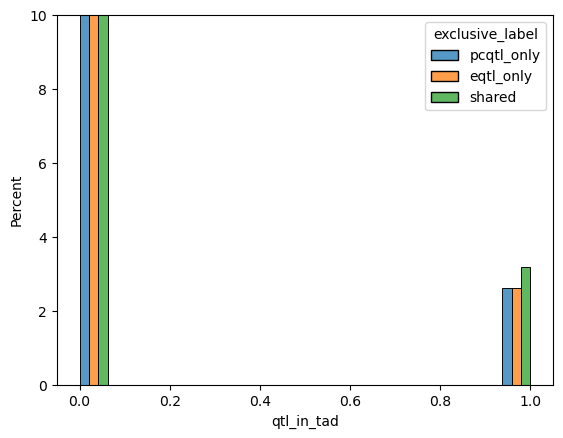

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qtl_in_tad', common_norm=False, stat='percent', multiple='dodge')
ax.set_ylim(0, 10)

ctcf

In [ ]:

qtls_grouped['tss_min'] = qtls_grouped['position']
qtls_grouped['tss_max'] = qtls_grouped['position']
qtls_grouped['Chromosome'] = qtls_grouped['chr']

annotated = []
for tissue_id, sub_qtl in qtls_grouped.groupby('tissue_id'):
    ctcf_df = load_ctcf(tissue_id)
    annotate_ctcf(sub_qtl, ctcf_df)
    annotated.append(sub_qtl)

qtls_grouped =  pd.concat(annotated)

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


In [ ]:
clusters = load_across_tissues(config, load_clusters_annotated)
qtls_grouped = pd.merge(qtls_grouped, clusters, left_on=['cluster_id', 'tissue_id'], right_on=['cluster_id', 'Tissue'], suffixes=['', '_cluster'], how='left')

In [ ]:
qtls_grouped['qtl_in_ctcf'] = qtls_grouped['has_ctcf_peak']
qtls_grouped['between_tss'] = ((qtls_grouped['tss_min_cluster'] < qtls_grouped['position']) & (qtls_grouped['tss_max_cluster'] > qtls_grouped['position']))
qtls_grouped['qtl_in_tss_ctcf'] = qtls_grouped['between_tss'] & qtls_grouped['qtl_in_ctcf']
qtls_grouped['qtl_in_tad_ctcf'] = qtls_grouped['qtl_in_tad'] & qtls_grouped['qtl_in_ctcf']


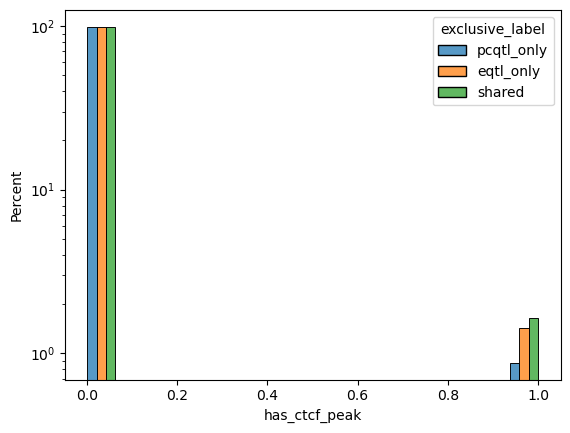

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='has_ctcf_peak', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')

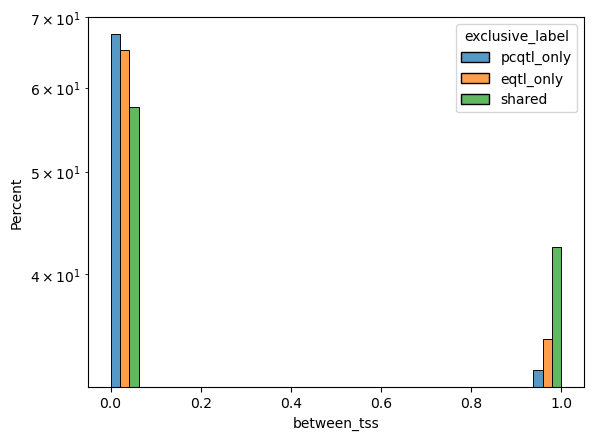

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='between_tss', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')

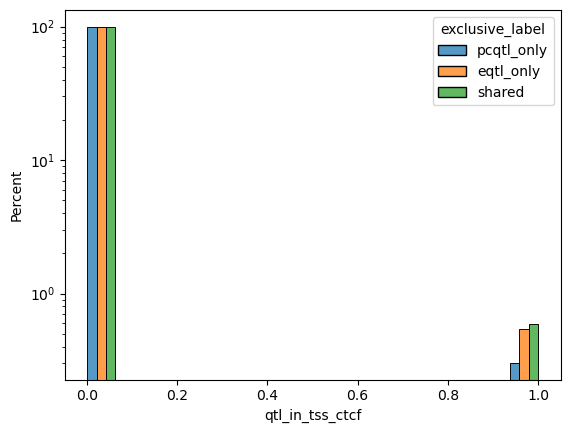

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qtl_in_tss_ctcf', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')

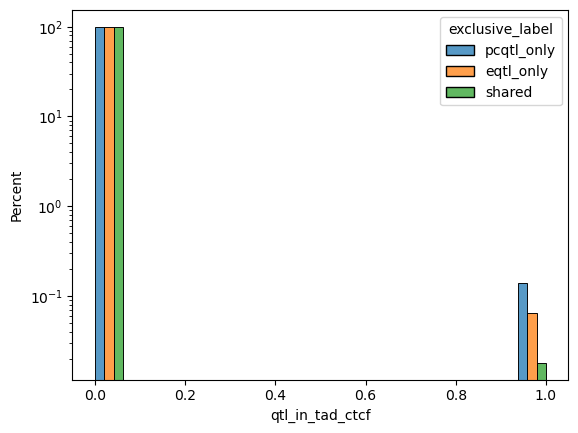

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='qtl_in_tad_ctcf', common_norm=False, stat='percent', multiple='dodge')
ax.set_yscale('log')

In [ ]:
qtls_grouped[qtls_grouped['qtl_in_tad_ctcf']]['pc_order'].value_counts()

pc_order
[last]           13
[eqtl]            7
[first]           2
[middle]          1
[first, eqtl]     1
Name: count, dtype: int64

In [ ]:
qtls_grouped.groupby('exclusive_label')['qtl_in_tad_ctcf'].value_counts()

exclusive_label  qtl_in_tad_ctcf
eqtl_only        False              10731
                 True                   7
pcqtl_only       False              11547
                 True                  16
shared           False               5575
                 True                   1
Name: count, dtype: int64

bidirectional promoter

In [ ]:
# in a bidirectional promoter?
qtls_grouped['in_bidirectional_promoter'] = False
qtls_grouped['in_shared_promoter'] = False
sub_qtls = qtls_grouped[qtls_grouped['has_bidirectional_promoter']]
for qtl_idx, row in tqdm(sub_qtls.iterrows(), total=len(sub_qtls)):
    transcript_ids = row['cluster_id'].split('_')
    cluster_gencode = gid_gencode.loc[transcript_ids]
    # in the promoter if within 1kb of tss_start
    for idx, first_gene_row in cluster_gencode.iterrows():
        for idx, second_gene_row in cluster_gencode.iterrows():
            opp_strand = first_gene_row['strand'] != second_gene_row['strand']
            close = abs(first_gene_row['tss_start'] - second_gene_row['tss_start']) <= 1000
            if opp_strand & close:
                # found a bidirectional promotor
                if ((row['position'] - first_gene_row['tss_start']) < 1000) & ((row['position'] - second_gene_row['tss_start']) < 1000):
                    qtls_grouped.loc[qtl_idx, 'in_bidirectional_promoter'] = True
            elif close:
                # found a shared promotor
                if ((row['position'] - first_gene_row['tss_start']) < 1000) & ((row['position'] - second_gene_row['tss_start']) < 1000):
                    qtls_grouped.loc[qtl_idx, 'in_shared_promoter'] = True


  0%|          | 0/3277 [00:00<?, ?it/s]

(0.0, 10.0)

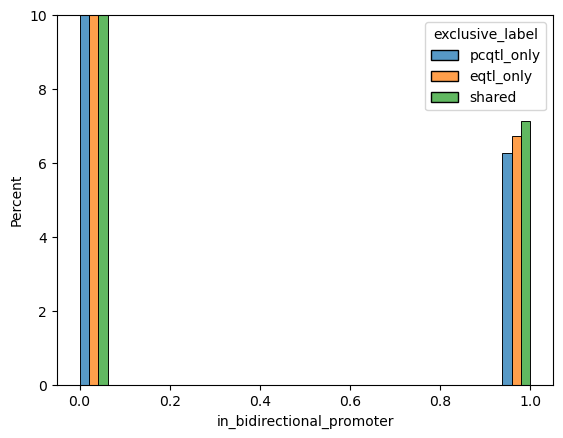

In [ ]:
ax = sns.histplot(data=qtls_grouped, hue='exclusive_label', x='in_bidirectional_promoter', stat='percent', common_norm=False, multiple='dodge')
ax.set_ylim(0, 10)

### compare cluster labels

<AxesSubplot: xlabel='has_high_pos_corr', ylabel='Percent'>

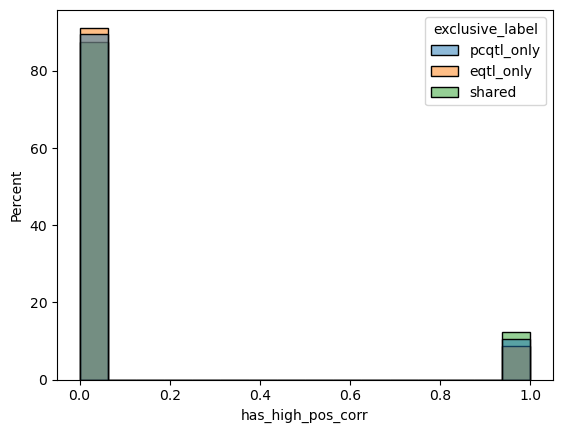

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='has_high_pos_corr', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_weighted', ylabel='Percent'>

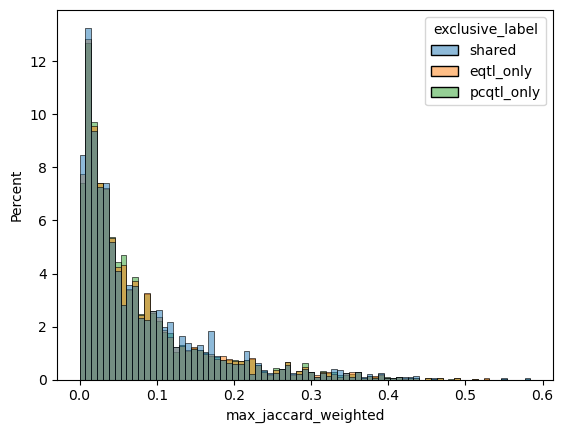

In [ ]:
sns.histplot(data=qtls_grouped[qtls_grouped['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_weighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='max_jaccard_unweighted', ylabel='Percent'>

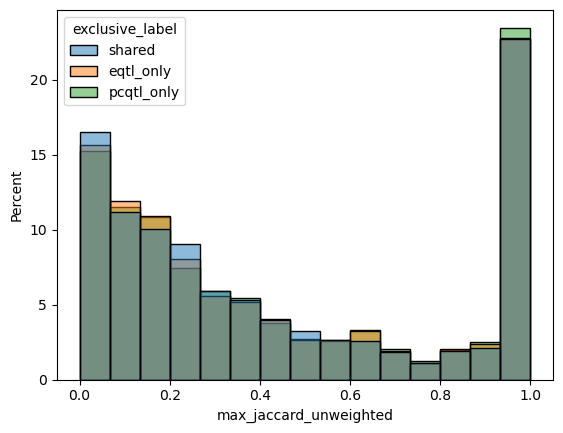

In [ ]:
sns.histplot(data=qtls_grouped[qtls_grouped['num_abc_genes']>1], hue='exclusive_label', x='max_jaccard_unweighted', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_shared_go_all', ylabel='Percent'>

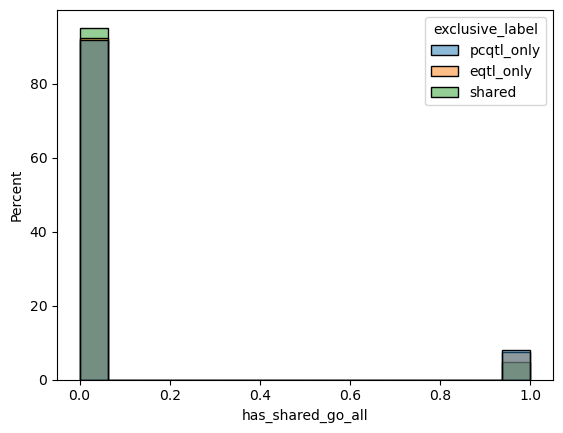

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='has_shared_go_all',e stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_cross_map', ylabel='Percent'>

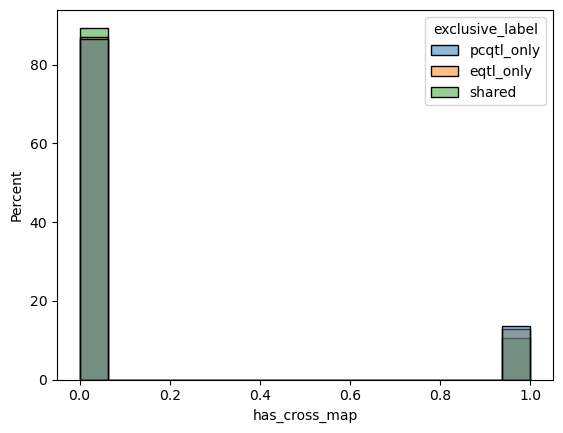

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='has_cross_map', stat='percent', common_norm=False)

<AxesSubplot: xlabel='has_paralog', ylabel='Percent'>

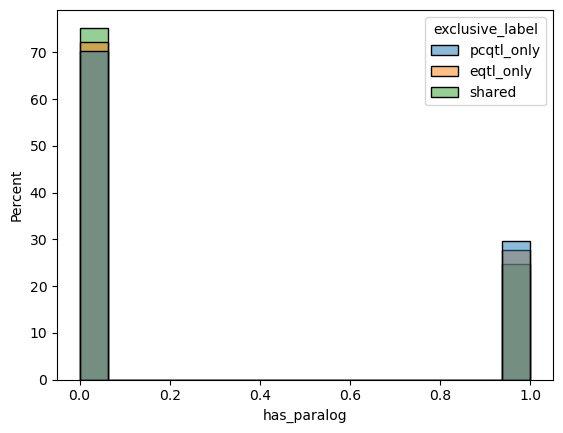

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='has_paralog', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_shared_strong_enhancers', ylabel='Percent'>

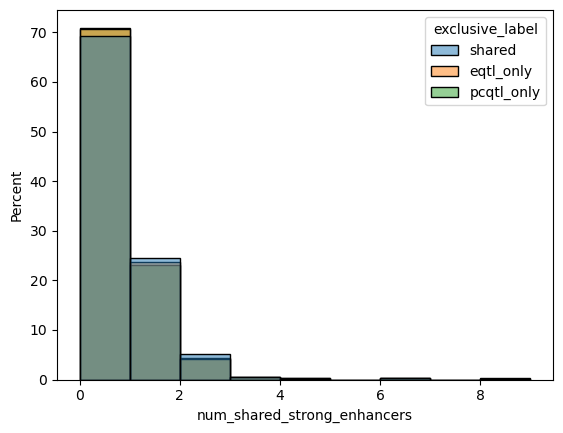

In [ ]:
sns.histplot(data=qtls_grouped[qtls_grouped['num_abc_genes']>1], hue='exclusive_label', x='num_shared_strong_enhancers', stat='percent', common_norm=False, bins=range(10))

<AxesSubplot: xlabel='num_shared_enhancers', ylabel='Percent'>

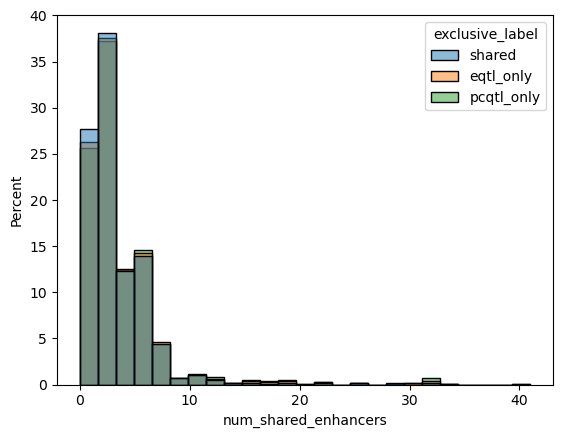

In [ ]:
sns.histplot(data=qtls_grouped[qtls_grouped['num_abc_genes']>1], hue='exclusive_label', x='num_shared_enhancers', stat='percent', common_norm=False, bins=25)

<AxesSubplot: xlabel='num_tads_tss', ylabel='Percent'>

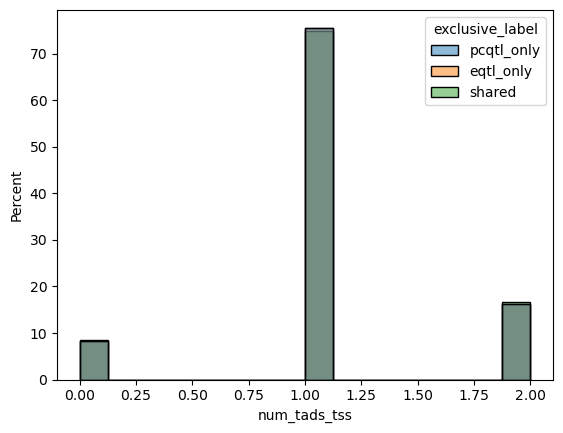

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='num_tads_tss', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_bidirectional_promoter', ylabel='Percent'>

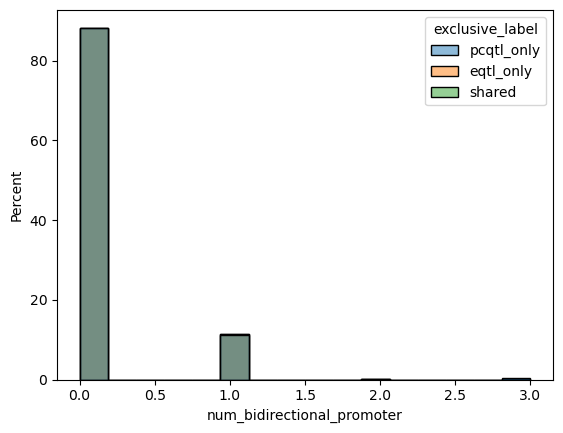

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='num_bidirectional_promoter', stat='percent', common_norm=False)

<AxesSubplot: xlabel='num_abc_genes', ylabel='Percent'>

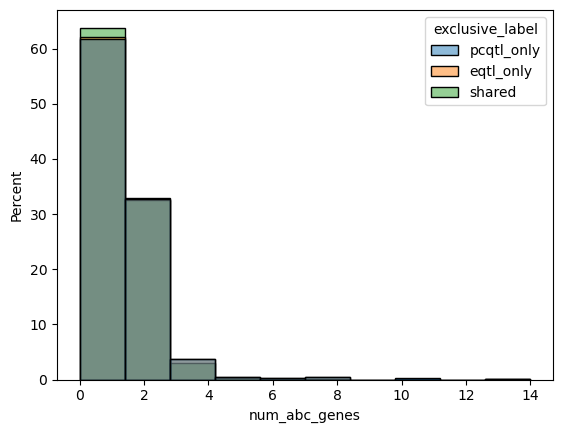

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='num_abc_genes', stat='percent', common_norm=False, bins=10)

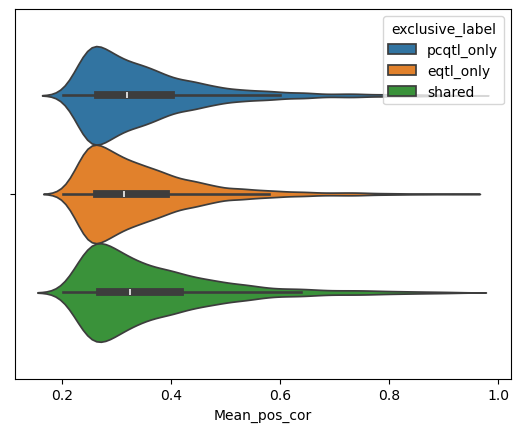

In [ ]:
ax=sns.violinplot(data=qtls_grouped, hue='exclusive_label', x='Mean_pos_cor')


In [ ]:
# try correctiong on distance
# distance to whichever gene in the cluster is closest
def get_tss(row):
    cluster_gene_df = gid_gencode.loc[row['cluster_id'].split('_')]
    starts = cluster_gene_df['tss_start'].values
    distances = row['position'] - starts
    # return smallest absolute value distance
    idx = np.argmin(abs(distances))
    # make relative to gene orientation
    if cluster_gene_df.iloc[idx]['strand'] == '-':
        return -distances[idx]
    else:
        return distances[idx]
    
qtls_grouped['cluster_min_distance'] = qtls_grouped.progress_apply(get_tss, axis=1)
qtls_grouped['log_qtl_distance'] = np.log10(qtls_grouped['cluster_min_distance'].abs() +1)


 ... (more hidden) ...

 ... (more hidden) ...


<AxesSubplot: xlabel='log_qtl_distance', ylabel='Percent'>

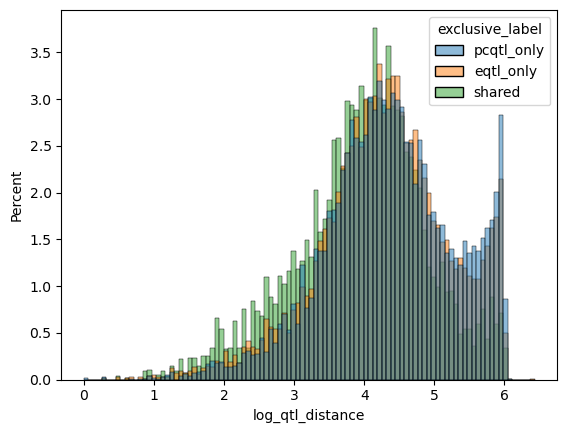

In [ ]:
sns.histplot(data=qtls_grouped, hue='exclusive_label', x='log_qtl_distance', stat='percent', common_norm=False, bins=100)

### make a log odds plot for this

In [ ]:
import statsmodels.api as sm

In [ ]:
# fit a logit model

def fit_logistic_model(joined_df, column, label_col, correct_on=False, filter_on_column=None, verb=True, correct_on_column='log_size'):
    if verb:
        print(column)
    try:
        final_joined_df = joined_df[joined_df[filter_on_column]]
    except KeyError:
        final_joined_df = joined_df

    if correct_on:
        x = final_joined_df[np.append(np.asarray(correct_on_column),column)].astype(float)
    else:
        x = final_joined_df[column].astype(float)

    y = final_joined_df.reset_index()[label_col].values.astype(bool)
    x_with_constant = sm.add_constant(x) # Add intercept term

    logit_model = sm.Logit(y, x_with_constant)
    try:
        result = logit_model.fit()
        
    except np.linalg.LinAlgError:
        # this can happen if all elements are the same
        return pd.Series({'lower_cb':np.nan, 'upper_cb':np.nan, 'odds_ratio':np.nan, 'p_value':np.nan, 'col':column,'lower_cb_diff':np.nan , 'upper_cb_diff':np.nan}, name=column)
        print(joined_df.head())
        print(column)
        sns.histplot(joined_df[column])
        raise np.linalg.LinAlgError
    if verb:
        print(result.summary())

    coefficients = result.params
    conf_int = result.conf_int()
    odds_ratios = np.exp(coefficients)
    odds_ratios_ci = np.exp(conf_int)

    odds_ratios_ci.rename(columns={0:'lower_cb', 1:'upper_cb'}, inplace=True)
    odds_ratios_ci['odds_ratio'] = odds_ratios
    odds_ratios_ci['p_value'] = result.pvalues
    odds_ratios_ci['col'] = column
    odds_ratios_ci['lower_cb_diff'] = odds_ratios_ci['odds_ratio'] - odds_ratios_ci['lower_cb']
    odds_ratios_ci['upper_cb_diff'] = odds_ratios_ci['upper_cb'] - odds_ratios_ci['odds_ratio']
    
    return odds_ratios_ci.loc[column]


def get_odds_df(joined_df, label_col='pcqtl_bool', verb=True, correct_on=False, correct_on_column='log_size', column_list = ['num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any','has_shared_enhancer',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted', 'has_tads_tss'], 
       filter_list=['max_jaccard_unweighted', 'max_jaccard_weighted', 'num_shared_strong_enhancers', 'num_shared_enhancers', 'has_shared_enhancer', 'qtl_matched_abc_genes', 'qtl_matched_abc_all_genes',  'qtl_num_abc_enhancers', 'qtl_num_abc_all_enhancers'], 
       filter_on_column = 'has_multiple_abc_genes'):
       column_list = pd.Series(column_list)
       odds_ratios_no_filter = pd.DataFrame([fit_logistic_model(joined_df, c, label_col, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[~column_list.isin(filter_list)]]) 
       odds_ratios_filtered = pd.DataFrame([fit_logistic_model(joined_df, c, label_col, filter_on_column=filter_on_column, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[column_list.isin(filter_list)]]) 
       return pd.concat([odds_ratios_no_filter, odds_ratios_filtered])

def make_log_odds_plot(log_odds_df, ax=None):
    log_odds_df = log_odds_df.reset_index()
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    # log odds plot
    ax.errorbar(y=log_odds_df['col'], x=log_odds_df['odds_ratio'], xerr=log_odds_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", color='k')
    ax.axvline(1, color='k', linestyle='--')
    ax.set_xlabel('Log odds')

    for idx,row in log_odds_df.iterrows():
        ax.annotate('OR: {:.2f},\np: {:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.2))
        #axes[0].annotate('log odds={:.1f}'.format(np.log(row['odds_ratio'])), (row['odds_ratio'], idx-.3))
    ax.set_xscale(u'log')
    return ax

# log odds plot with multiple odds per category 
def make_log_odds_plot_multiple(odds_ratios_list, ax=None, labels=None, add_annotations=True, offset = 0.2, colors = sns.color_palette()):
    
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    
    for idx, odds_ratio_df in enumerate(odds_ratios_list):
        odds_ratio_df = odds_ratio_df.reindex(odds_ratios_list[0].index).reset_index()
        color = colors[idx % len(colors)]  # cycle through colors if more than available
        ax.errorbar(y=odds_ratio_df.reset_index().index.values + idx*offset, x=odds_ratio_df['odds_ratio'], 
                    xerr=odds_ratio_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", 
                    color=color, label=labels[idx] if labels else None, markersize=3)
        ax.axvline(1, color='k', linestyle='--')

        if add_annotations:
            for row_idx, row in odds_ratio_df.iterrows():
                ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), 
                            (row['odds_ratio'], row_idx + idx*offset + 0.05), fontsize=6)
            
    if labels:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))

    ax.set_xscale(u'log')
    ax.set_yticks(ticks=odds_ratio_df.index.values + (len(odds_ratios_list)-1)*offset/2, labels=(odds_ratio_df['col']))
    return ax

In [ ]:
qtls_grouped['pcqtl_bool'] = qtls_grouped['type'].astype(str).str.contains('pcqtl')
qtls_grouped['pcqtl_only_bool'] = qtls_grouped['exclusive_label'] == 'pcqtl_only'
qtls_grouped['qtl_distance'] = np.log10(qtls_grouped['cluster_tss_size'])

num_bidirectional_promoter
Optimization terminated successfully.
         Current function value: 0.666549
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                27877
Model:                          Logit   Df Residuals:                    27875
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:               1.831e-07
Time:                        11:18:23   Log-Likelihood:                -18581.
converged:                       True   LL-Null:                       -18581.
Covariance Type:            nonrobust   LLR p-value:                    0.9343
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.4672      0.013 

<AxesSubplot: >

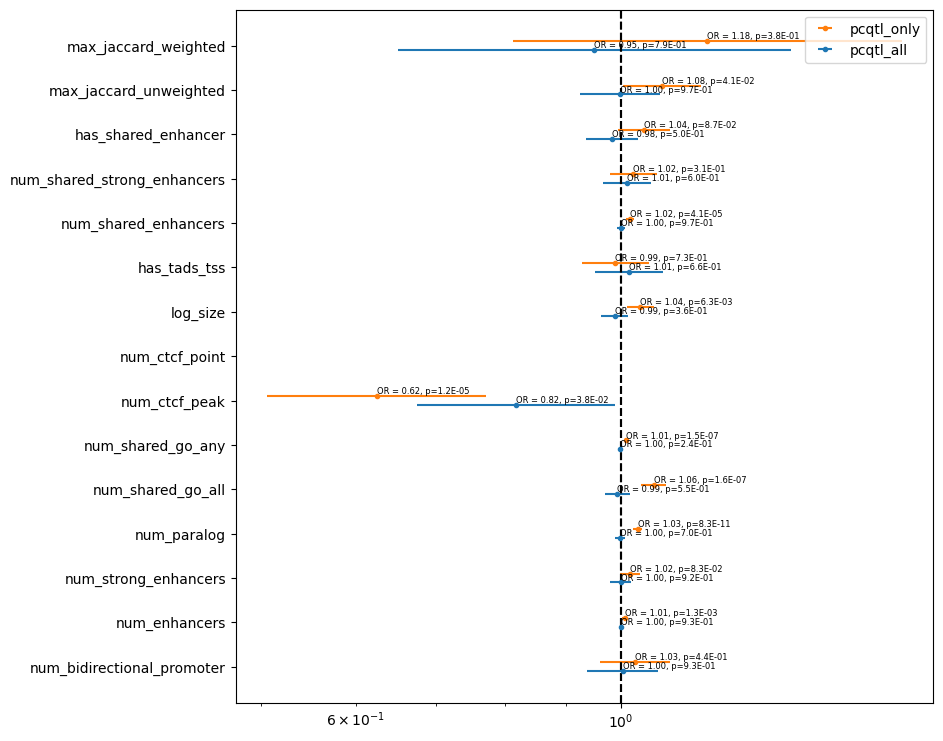

In [ ]:
make_log_odds_plot_multiple([get_odds_df(qtls_grouped, label_col='pcqtl_bool'), 
                             get_odds_df(qtls_grouped, label_col='pcqtl_only_bool')], labels=['pcqtl_all', 'pcqtl_only'])

median_expression
Optimization terminated successfully.
         Current function value: 0.666549
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                27877
Model:                          Logit   Df Residuals:                    27875
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:               1.091e-07
Time:                        11:21:15   Log-Likelihood:                -18581.
converged:                       True   LL-Null:                       -18581.
Covariance Type:            nonrobust   LLR p-value:                    0.9492
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4677      0.013     37.290      0.000       0.443   

<AxesSubplot: >

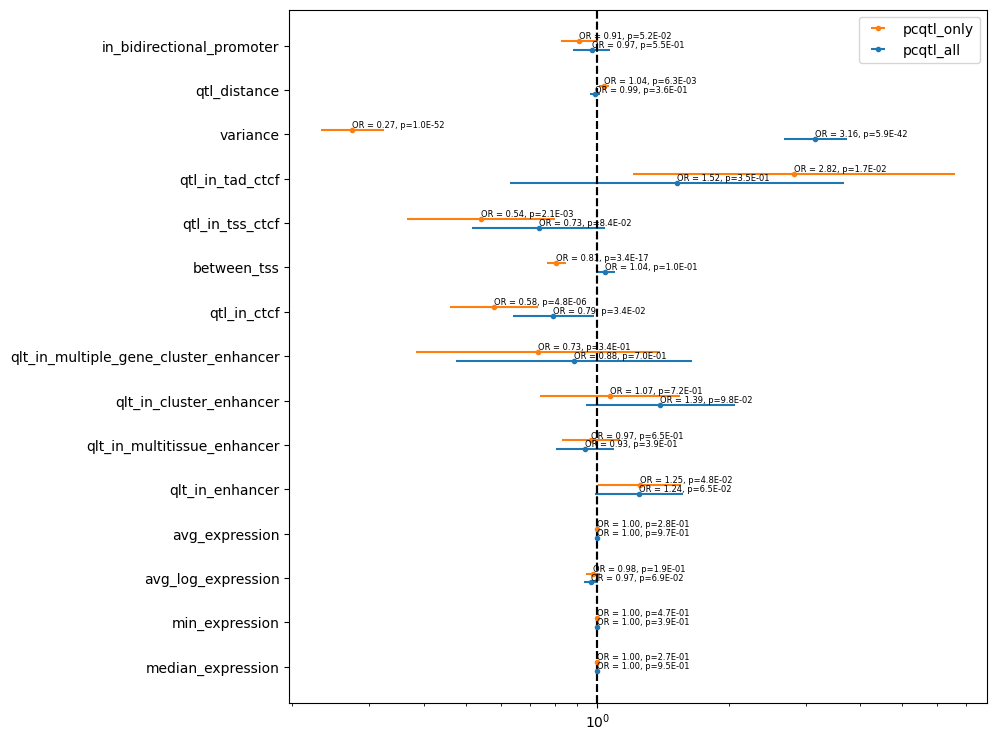

In [ ]:
qtl_columns= ['median_expression', 'min_expression', 'avg_log_expression', 'avg_expression', 
              'qlt_in_enhancer', 'qlt_in_multitissue_enhancer', 'qlt_in_cluster_enhancer', 'qlt_in_multiple_gene_cluster_enhancer',
              'qtl_in_ctcf', 'between_tss', 'qtl_in_tss_ctcf', 'qtl_in_tad_ctcf', 'variance', 'qtl_distance', 'in_bidirectional_promoter']





make_log_odds_plot_multiple([get_odds_df(qtls_grouped, label_col='pcqtl_bool', column_list=qtl_columns), 
                             get_odds_df(qtls_grouped, label_col='pcqtl_only_bool', column_list=qtl_columns)], 
                             labels=['pcqtl_all', 'pcqtl_only'])

median_expression
Optimization terminated successfully.
         Current function value: 0.679858
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1806
Model:                          Logit   Df Residuals:                     1804
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:               0.0002373
Time:                        11:25:54   Log-Likelihood:                -1227.8
converged:                       True   LL-Null:                       -1228.1
Covariance Type:            nonrobust   LLR p-value:                    0.4452
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3156      0.050     -6.350      0.000      -0.413   

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1806
Model:                          Logit   Df Residuals:                     1804
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                 0.02144
Time:                        11:25:55   Log-Likelihood:                -1201.8
converged:                       True   LL-Null:                       -1228.1
Covariance Type:            nonrobust   LLR p-value:                 3.959e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1389      0.083      1.669      0.095      -0.024       0.302
variance      -2.1994      0.335     -6.560      0.000      -2.857      -1.542
qtl_distance
Optimization terminated successfully.
 

(0.1, 10)

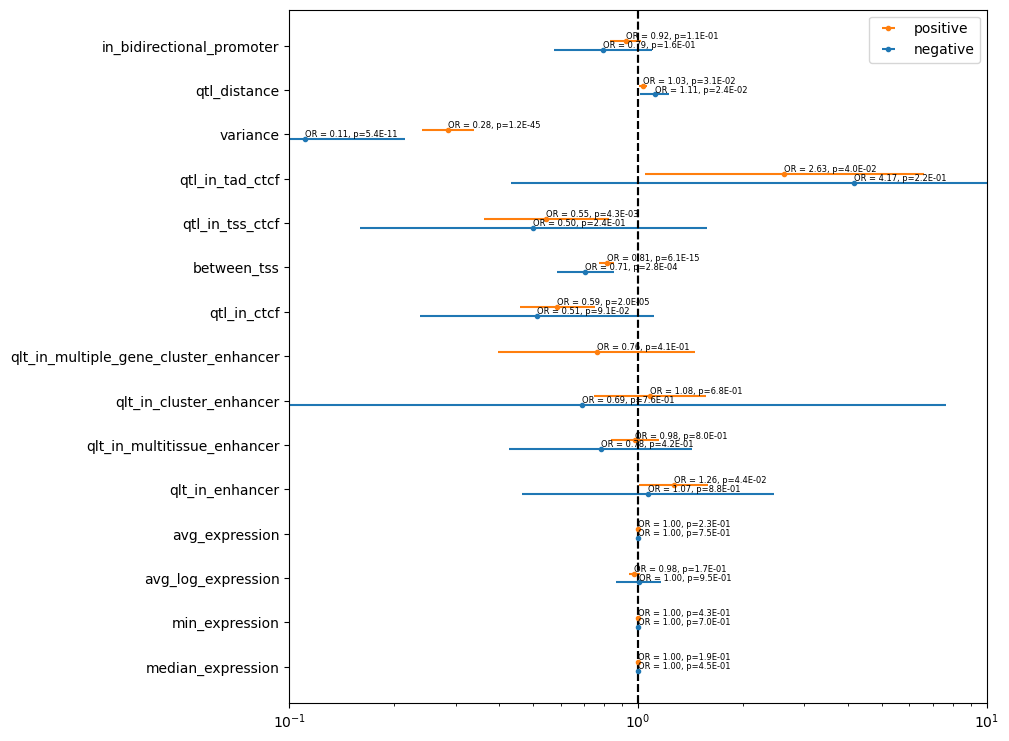

In [ ]:
ax = make_log_odds_plot_multiple([get_odds_df(qtls_grouped[~qtls_grouped['Mean_neg_cor'].isna()], label_col='pcqtl_only_bool', column_list=qtl_columns), 
                             get_odds_df(qtls_grouped[qtls_grouped['Mean_neg_cor'].isna()], label_col='pcqtl_only_bool', column_list=qtl_columns)], 
                             labels=['negative', 'positive'])
ax.set_xlim(.1, 10)

In [ ]:
qtls_grouped['num_e_samelead'] > 1

median_expression
Optimization terminated successfully.
         Current function value: 0.192888
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                16314
Model:                          Logit   Df Residuals:                    16312
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:               0.0002517
Time:                        11:28:55   Log-Likelihood:                -3146.8
converged:                       True   LL-Null:                       -3147.6
Covariance Type:            nonrobust   LLR p-value:                    0.2081
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.9732      0.038    -78.489      0.000      -3.047   

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                16314
Model:                          Logit   Df Residuals:                    16312
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:               6.961e-05
Time:                        11:28:56   Log-Likelihood:                -3147.3
converged:                       True   LL-Null:                       -3147.6
Covariance Type:            nonrobust   LLR p-value:                    0.5080
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9879      0.037    -80.949      0.000      -3.060      -2.916
qtl_in_ctcf     0.1888      0.278      0.680      0.497      -0.356       0.733
between_tss
Optimization terminated successfully

/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                16314
Model:                          Logit   Df Residuals:                    16312
Method:                           MLE   Df Model:                            1
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                 0.03288
Time:                        11:28:57   Log-Likelihood:                -3044.1
converged:                       True   LL-Null:                       -3147.6
Covariance Type:            nonrobust   LLR p-value:                 6.322e-47
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3139      0.046    -72.786      0.000      -3.403      -3.225
variance       1.6880      0.114     14.815      0.000       1.465       1.911
qtl_distance
Optimization terminated successfully.
 

<AxesSubplot: >

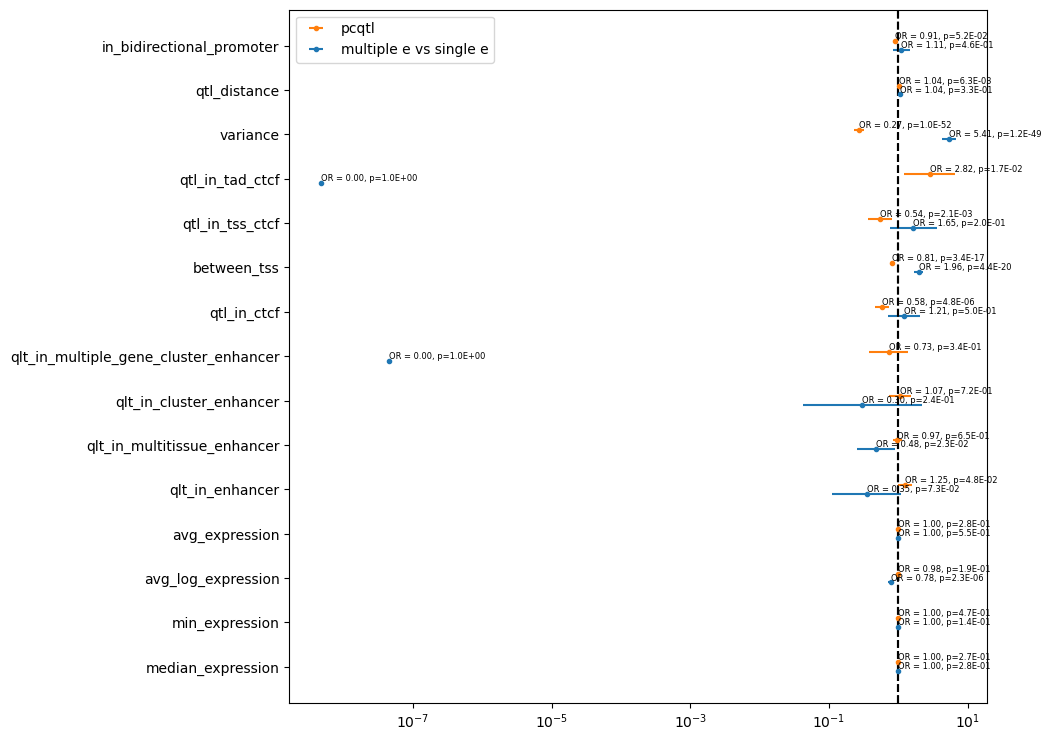

In [ ]:

make_log_odds_plot_multiple([get_odds_df(qtls_grouped[qtls_grouped['num_e_samelead']>0], label_col='multiple_e_bool', column_list=qtl_columns), 
                             get_odds_df(qtls_grouped, label_col='pcqtl_only_bool', column_list=qtl_columns)], 
                             labels=['multiple e vs single e', 'pcqtl'])

### vep

I need to get more annotations, so I'll run vep on this

In [ ]:
qtls_cluster_annotated['minor_af'] = np.where(qtls_cluster_annotated['af']>.5, 1-qtls['af'], qtls_cluster_annotated['af'])
